In [2]:
import sys

sys.path.append("/Users/alexanderveicht/Desktop/code/eth/master/3d-vision.nosync/RefinedMegaDepth/external_dependencies/pyceres")

In [34]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import pyceres
import pycolmap
import numpy as np
from hloc.utils import viz_3d
from copy import deepcopy
import cv2

from hloc.utils.io import list_h5_names, get_matches, get_keypoints
from hloc.visualization import plot_images, plot_matches, read_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
imc_dir = Path("../image-matching-challenge-2023")
outputs = Path("../outputs")

MODE = "train"
NAME = "SP+LG+sift+NN-rot-pixsfm-sci"
dataset = "heritage" # "heritage", "haiper", "urban"
scene = "cyprus" # "dioscuri", "cyprus", "wall", "kyiv-puppet-theater", "bike", "chairs", "fountain"

image_dir = imc_dir / MODE / dataset / scene / "images"


features_path = outputs / NAME / dataset / scene / "features.h5"
matches_path = outputs / NAME / dataset / scene / "matches.h5"

pairs_path = outputs / NAME / dataset / scene / "pairs.txt"

features_path.exists(), matches_path.exists(), pairs_path.exists()

(True, True, True)

# Calculate pairwise relative poses

In [160]:
pairs = []
with open(pairs_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        pairs.append(line.split())
    
idx = 54
name0 = pairs[idx][0]
name1 = pairs[idx][1]

name0, name1

('DSC_6577.JPG', 'DSC_6621.JPG')

In [161]:
name0, name1 = 'DSC_6488.JPG', 'DSC_6492.JPG'

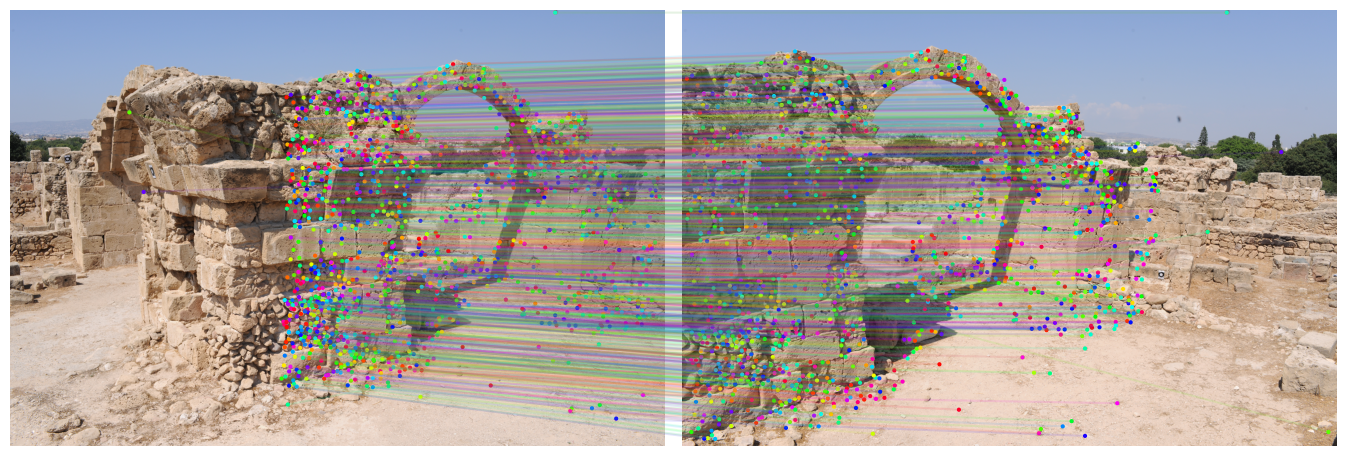

In [162]:
# plot images
plot_images([read_image(image_dir / name0), read_image(image_dir / name1)])
kp0, kp1 = get_keypoints(features_path, name0), get_keypoints(features_path, name1)
m, sc = get_matches(matches_path, name0, name1)
plot_matches(kp0[m[:,0]], kp1[m[:,1]], a=0.1)

In [164]:
camera0 = pycolmap.infer_camera_from_image(image_dir / name0)
camera1 = pycolmap.infer_camera_from_image(image_dir / name1)

print(camera0.summary())
print(camera1.summary())

Camera:
	camera_id=Invalid
	model = SIMPLE_RADIAL
	width = 6048
	height = 4032
	num_params = 4
	params_info = f, cx, cy, k
	params = 4838.400000, 3024.000000, 2016.000000, 0.000000
Camera:
	camera_id=Invalid
	model = SIMPLE_RADIAL
	width = 6048
	height = 4032
	num_params = 4
	params_info = f, cx, cy, k
	params = 4838.400000, 3024.000000, 2016.000000, 0.000000


In [165]:
points2D0 = [p for p in kp0[m[:, 0]].astype(np.float64)]
points2D1 = [p for p in kp1[m[:, 1]].astype(np.float64)]

type(points2D1), type(points2D1[0]), type(points2D1[0][0])

(list, numpy.ndarray, numpy.float64)

In [166]:
options = pycolmap.TwoViewGeometryOptions()

pycolmap.two_view_geometry_estimation(
    points2D1=points2D0,
    points2D2=points2D1,
    camera1=camera0,
    camera2=camera1,
    options=options,
)

TypeError: two_view_geometry_estimation(): incompatible function arguments. The following argument types are supported:
    1. (points2D1: List[numpy.ndarray[numpy.float64[2, 1]]], points2D2: List[numpy.ndarray[numpy.float64[2, 1]]], camera1: colmap::Camera, camera2: colmap::Camera, estimation_options: pycolmap.TwoViewGeometryOptions = <pycolmap.TwoViewGeometryOptions object at 0x10bae34f0>) -> dict
    2. (points2D1: List[numpy.ndarray[numpy.float64[2, 1]]], points2D2: List[numpy.ndarray[numpy.float64[2, 1]]], camera1: colmap::Camera, camera2: colmap::Camera, max_error_px: float = 4.0, min_inlier_ratio: float = 0.01, min_num_trials: int = 1000, max_num_trials: int = 100000, confidence: float = 0.9999) -> dict

Invoked with: kwargs: points2D1=[array([4112. ,  586.5]), array([4264. ,  627.5]), array([3992. ,  678.5]), array([3750. ,  697.5]), array([3750. ,  697.5]), array([4208. ,  694.5]), array([4260.,  698.]), array([4324.,  703.]), array([4308.,  714.]), array([3820.,  776.]), array([3798. ,  794.5]), array([4500. ,  795.5]), array([4536. ,  807.5]), array([4700.,  804.]), array([3330. ,  888.5]), array([3416. ,  894.5]), array([4524. ,  962.5]), array([5156. ,  995.5]), array([5156. ,  995.5]), array([4736., 1020.]), array([5284., 1020.]), array([5260., 1025.]), array([5104., 1031.]), array([5104., 1031.]), array([5312., 1034.]), array([4988., 1045.]), array([4988., 1045.]), array([4648., 1061.]), array([5048., 1071.]), array([5048., 1071.]), array([3672., 1103.]), array([3672., 1103.]), array([4784., 1101.]), array([4888., 1115.]), array([3712., 1181.]), array([5236., 1178.]), array([5208., 1190.]), array([5336., 1214.]), array([4636., 1228.]), array([4636., 1228.]), array([3850., 1208.]), array([4628., 1253.]), array([4628., 1253.]), array([2966., 1267.]), array([4948., 1267.]), array([4636., 1281.]), array([5596., 1254.]), array([3990., 1266.]), array([4030., 1265.]), array([2766., 1295.]), array([3022., 1303.]), array([5368., 1318.]), array([5148., 1326.]), array([4984., 1328.]), array([5524., 1308.]), array([5324., 1333.]), array([5324., 1333.]), array([5348., 1338.]), array([5092., 1345.]), array([5580., 1327.]), array([5400., 1357.]), array([3794., 1366.]), array([5416., 1378.]), array([5416., 1378.]), array([5340., 1389.]), array([4496., 1419.]), array([4644., 1445.]), array([3968., 1437.]), array([5412., 1460.]), array([5500., 1462.]), array([5212., 1470.]), array([4940., 1479.]), array([5360., 1494.]), array([3244., 1471.]), array([3244., 1471.]), array([3086., 1474.]), array([3114., 1474.]), array([5876., 1517.]), array([4808., 1520.]), array([5576., 1530.]), array([5212., 1557.]), array([5212., 1557.]), array([5192., 1564.]), array([5952., 1586.]), array([4620., 1586.]), array([4408., 1591.]), array([3758., 1581.]), array([3758., 1581.]), array([3374., 1583.]), array([4908., 1621.]), array([5976., 1643.]), array([5348., 1636.]), array([4656., 1643.]), array([4656., 1643.]), array([5676., 1656.]), array([5516., 1662.]), array([4328., 1648.]), array([5600., 1676.]), array([4356., 1676.]), array([4624., 1751.]), array([5644., 1813.]), array([3688., 1755.]), array([4132., 1805.]), array([5576., 1846.]), array([2834., 1754.]), array([5700., 1854.]), array([5360., 1855.]), array([4520., 1855.]), array([5424., 1898.]), array([2564., 1809.]), array([5772., 1969.]), array([3992., 1921.]), array([5572., 1977.]), array([5572., 1977.]), array([5896., 1998.]), array([5520., 2023.]), array([2934., 1912.]), array([5032., 2041.]), array([5032., 2041.]), array([5396., 2058.]), array([2568., 3648.]), array([5296., 2082.]), array([5296., 2082.]), array([5964., 2150.]), array([3854., 2072.]), array([3854., 2072.]), array([4252., 2100.]), array([5916., 2180.]), array([2636., 2000.]), array([5860., 2198.]), array([3624., 2106.]), array([4484., 2208.]), array([4476., 2236.]), array([5808., 2296.]), array([5840., 2306.]), array([3830., 2256.]), array([4508., 2302.]), array([4480., 2310.]), array([4580., 2380.]), array([5608., 2438.]), array([3548., 2298.]), array([5084., 2428.]), array([5292., 2452.]), array([3622., 2332.]), array([4284., 2422.]), array([3836., 2414.]), array([3112., 2322.]), array([4208., 2454.]), array([4424., 2466.]), array([4576., 2486.]), array([3746., 2442.]), array([4520., 2502.]), array([3828., 2464.]), array([4696., 2514.]), array([3976., 2514.]), array([4412., 2552.]), array([5420., 2612.]), array([3856., 2542.]), array([5256., 2616.]), array([4832., 2600.]), array([3888., 2556.]), array([5612., 2656.]), array([5476., 2654.]), array([5476., 2654.]), array([5932., 2684.]), array([5724., 2682.]), array([5724., 2682.]), array([5804., 2688.]), array([3584., 2522.]), array([5804., 2742.]), array([4584., 2678.]), array([5264., 2738.]), array([5612., 2766.]), array([5844., 2776.]), array([5912., 2818.]), array([5484., 2808.]), array([5804., 2832.]), array([5152., 2796.]), array([4748., 2774.]), array([5820., 2850.]), array([4880., 2802.]), array([3070., 2642.]), array([3504., 2744.]), array([4988., 2898.]), array([4988., 2898.]), array([3570., 2764.]), array([3994., 2836.]), array([3058., 2824.]), array([3960., 2984.]), array([3694., 3016.]), array([2528., 2882.]), array([4184., 3116.]), array([2696., 2962.]), array([2692., 3040.]), array([3916., 3224.]), array([3172., 3160.]), array([3500., 3232.]), array([3520., 3320.]), array([2922., 3380.]), array([1103.,  947.]), array([2624., 3456.]), array([5040.    ,   24.8125]), array([5040.    ,   24.8125]), array([3210.,  562.]), array([4244. ,  501.5]), array([4042.,  518.]), array([3326.,  614.]), array([4088. ,  572.5]), array([4384.,  580.]), array([4384.,  580.]), array([3086.,  648.]), array([2866.,  646.]), array([3122. ,  653.5]), array([3216. ,  680.5]), array([4496.,  627.]), array([4336. ,  639.5]), array([4380. ,  642.5]), array([4022.,  666.]), array([2852.,  760.]), array([3688.,  735.]), array([4136.,  727.]), array([4360.,  719.]), array([3570. ,  755.5]), array([2556.,  807.]), array([3358.,  778.]), array([3552. ,  790.5]), array([2962. ,  823.5]), array([2962. ,  823.5]), array([3208. ,  815.5]), array([4684. ,  839.5]), array([2656.,  912.]), array([4748. ,  842.5]), array([4572. ,  853.5]), array([3392. ,  898.5]), array([4724. ,  884.5]), array([4724. ,  884.5]), array([3312.,  933.]), array([4628.,  908.]), array([3184.,  962.]), array([4680. ,  932.5]), array([4656. ,  940.5]), array([3104. ,  978.5]), array([2646. ,  993.5]), array([3214. ,  983.5]), array([3214. ,  983.5]), array([4700. ,  959.5]), array([3682. ,  987.5]), array([3682. ,  987.5]), array([3394., 1000.]), array([3394., 1000.]), array([3290., 1018.]), array([3494., 1029.]), array([3544., 1071.]), array([5188., 1046.]), array([5188., 1046.]), array([5228., 1048.]), array([3148., 1090.]), array([5188., 1075.]), array([5188., 1075.]), array([5276., 1090.]), array([4852., 1112.]), array([3626., 1130.]), array([4800., 1124.]), array([2656., 1164.]), array([5028., 1148.]), array([3618., 1170.]), array([4944., 1167.]), array([5044., 1168.]), array([2870., 1193.]), array([3190., 1214.]), array([2720., 1228.]), array([2720., 1228.]), array([2898., 1229.]), array([5156., 1229.]), array([2564., 1244.]), array([3480., 1244.]), array([4980., 1239.]), array([2594., 1253.]), array([5240., 1259.]), array([3346., 1271.]), array([5156., 1291.]), array([2728., 1293.]), array([5580., 1285.]), array([3464., 1314.]), array([5100., 1321.]), array([5048., 1321.]), array([2718., 1320.]), array([5296., 1346.]), array([4568., 1347.]), array([3176., 1346.]), array([3512., 1353.]), array([3980., 1339.]), array([2592., 1352.]), array([5144., 1368.]), array([3482., 1366.]), array([4904., 1378.]), array([5364., 1382.]), array([5364., 1382.]), array([2666., 1370.]), array([3762., 1376.]), array([3066., 1381.]), array([5372., 1411.]), array([4632., 1467.]), array([2762., 1465.]), array([4664., 1491.]), array([3558., 1479.]), array([3438., 1481.]), array([5504., 1510.]), array([2956., 1480.]), array([2608., 1484.]), array([4848., 1519.]), array([3636., 1501.]), array([5988., 1560.]), array([5236., 1563.]), array([4420., 1569.]), array([4656., 1579.]), array([5636., 1595.]), array([2702., 1560.]), array([3572., 1596.]), array([2594., 1578.]), array([5192., 1634.]), array([4552., 1634.]), array([5920., 1662.]), array([5968., 1668.]), array([2784., 1605.]), array([3644., 1624.]), array([3572., 1631.]), array([5940., 1691.]), array([2670., 1612.]), array([2920., 1626.]), array([5932., 1715.]), array([5404., 1702.]), array([5976., 1722.]), array([6004., 1722.]), array([4924., 1704.]), array([2918., 1652.]), array([5588., 1759.]), array([3650., 1704.]), array([4880., 1777.]), array([4772., 1795.]), array([2630., 1721.]), array([4884., 1803.]), array([5536., 1823.]), array([4192., 1811.]), array([4320., 1816.]), array([5540., 1849.]), array([5540., 1849.]), array([3514., 1782.]), array([4084., 1829.]), array([5388., 1855.]), array([5300., 1871.]), array([5300., 1871.]), array([2646., 1782.]), array([4300., 1877.]), array([2990., 1820.]), array([4384., 1902.]), array([5600., 1931.]), array([2754., 1818.]), array([4072., 1907.]), array([3456., 1863.]), array([3392., 1863.]), array([3494., 1893.]), array([3494., 1893.]), array([3614., 1906.]), array([3614., 1906.]), array([3570., 1905.]), array([3570., 1905.]), array([3794., 1950.]), array([3050., 1890.]), array([5296., 2001.]), array([2722., 1902.]), array([3656., 1955.]), array([4988., 2034.]), array([4988., 2034.]), array([3216., 1949.]), array([4704., 2047.]), array([2762., 1956.]), array([2632., 1952.]), array([2632., 1952.]), array([3936., 2058.]), array([3060., 1989.]), array([3504., 2030.]), array([3954., 2090.]), array([3094., 2018.]), array([3198., 2023.]), array([3198., 2023.]), array([4656., 2130.]), array([5932., 2206.]), array([4756., 2162.]), array([4756., 2162.]), array([4516., 2162.]), array([4644., 2170.]), array([3792., 2152.]), array([5632., 2220.]), array([5632., 2220.]), array([3778., 2194.]), array([3948., 2210.]), array([3068., 2114.]), array([3942., 2234.]), array([3550., 2172.]), array([3810., 2242.]), array([5856., 2358.]), array([4336., 2312.]), array([3966., 2304.]), array([5560., 2380.]), array([3566., 2248.]), array([4840., 2376.]), array([4088., 2350.]), array([3480., 2270.]), array([3798., 2354.]), array([3798., 2354.]), array([3004., 2258.]), array([3612., 2314.]), array([3972., 2386.]), array([5060., 2448.]), array([4034., 2432.]), array([4640., 2468.]), array([3482., 2354.]), array([5416., 2498.]), array([5824., 2538.]), array([2978., 2340.]), array([2978., 2340.]), array([3546., 2396.]), array([2786., 2352.]), array([3214., 2388.]), array([3688., 2482.]), array([4288., 2518.]), array([2680., 2364.]), array([4860., 2566.]), array([3428., 2428.]), array([3428., 2428.]), array([3072., 2424.]), array([3048., 2424.]), array([4940., 2608.]), array([3380., 2474.]), array([3806., 2560.]), array([5660., 2664.]), array([5900., 2676.]), array([5076., 2662.]), array([3206., 2494.]), array([5808., 2714.]), array([5808., 2714.]), array([3168., 2496.]), array([3950., 2622.]), array([2714., 2476.]), array([5136., 2706.]), array([4856., 2714.]), array([3060., 2548.]), array([4200., 2686.]), array([3936., 2676.]), array([5244., 2756.]), array([5568., 2800.]), array([5948., 2828.]), array([2890., 2570.]), array([3310., 2632.]), array([5296., 2820.]), array([5364., 2826.]), array([2786., 2592.]), array([2654., 2582.]), array([5040., 2822.]), array([4752., 2814.]), array([5800., 2896.]), array([3186., 2670.]), array([5840., 2908.]), array([2948., 2662.]), array([2948., 2662.]), array([3594., 2742.]), array([3058., 2692.]), array([5472., 2924.]), array([2892., 2690.]), array([2930., 2694.]), array([2930., 2694.]), array([3638., 2770.]), array([5052., 2916.]), array([2682., 2688.]), array([2890., 2714.]), array([3966., 2848.]), array([3200., 2752.]), array([3338., 2772.]), array([2564., 2698.]), array([2592., 2698.]), array([2688., 2708.]), array([2688., 2708.]), array([3068., 2754.]), array([5472., 2980.]), array([5192., 2962.]), array([5396., 2990.]), array([2702., 2728.]), array([2570., 2720.]), array([3244., 2794.]), array([2806., 2762.]), array([3858., 2902.]), array([3146., 2800.]), array([2748., 2768.]), array([2814., 2782.]), array([2814., 2782.]), array([3606., 2894.]), array([3606., 2894.]), array([3992., 2976.]), array([2854., 2852.]), array([2900., 2888.]), array([3880., 3036.]), array([3024., 2924.]), array([4888., 3116.]), array([4888., 3116.]), array([2878., 2910.]), array([2878., 2910.]), array([2738., 2902.]), array([2818., 2918.]), array([2536., 2908.]), array([2754., 2952.]), array([3112., 3022.]), array([3084., 3050.]), array([2848., 3058.]), array([3704., 3174.]), array([3408., 3158.]), array([3144., 3162.]), array([3028., 3154.]), array([2622., 3112.]), array([3500., 3256.]), array([3364., 3244.]), array([2772., 3174.]), array([3742., 3332.]), array([3152., 3272.]), array([3650., 3324.]), array([2764., 3220.]), array([2708., 3216.]), array([2540., 3196.]), array([3058., 3276.]), array([3096., 3286.]), array([5852., 3560.]), array([3064., 3302.]), array([3132., 3330.]), array([3160., 3348.]), array([4444., 3472.]), array([3026., 3340.]), array([3026., 3340.]), array([2592., 3298.]), array([3190., 3418.]), array([5452., 3652.]), array([2740., 3408.]), array([5380., 3682.]), array([3122., 3470.]), array([5192., 3684.]), array([2510., 3408.]), array([2594., 3474.]), array([2650., 3482.]), array([4380.,  548.]), array([3240.,  614.]), array([3344. ,  706.5]), array([3840.,  679.]), array([3248.,  730.]), array([3248.,  730.]), array([4568. ,  684.5]), array([3034.,  756.]), array([2714. ,  810.5]), array([3194.,  787.]), array([3394.,  782.]), array([2832.,  813.]), array([3296. ,  817.5]), array([3296. ,  817.5]), array([3462. ,  818.5]), array([3556. ,  820.5]), array([3782. ,  804.5]), array([2908.,  864.]), array([4668.,  805.]), array([2702. ,  909.5]), array([2934.,  920.]), array([3476. ,  933.5]), array([3544.,  960.]), array([5212. ,  961.5]), array([3480., 1008.]), array([3570., 1035.]), array([3570., 1035.]), array([3658., 1082.]), array([3658., 1082.]), array([5224., 1079.]), array([3584., 1099.]), array([3584., 1099.]), array([4840., 1082.]), array([3200., 1173.]), array([4604., 1154.]), array([5216., 1158.]), array([2704., 1187.]), array([2614., 1197.]), array([2892., 1208.]), array([5024., 1200.]), array([2834., 1217.]), array([4804., 1205.]), array([5228., 1227.]), array([5228., 1227.]), array([5128., 1242.]), array([3308., 1254.]), array([3484., 1268.]), array([3484., 1268.]), array([5180., 1269.]), array([3408., 1284.]), array([3212., 1292.]), array([3090., 1294.]), array([3520., 1293.]), array([3352., 1296.]), array([3066., 1298.]), array([4932., 1320.]), array([4932., 1320.]), array([2574., 1331.]), array([3420., 1335.]), array([3288., 1345.]), array([1235., 1683.]), array([3654., 1374.]), array([5264., 1380.]), array([2572., 1374.]), array([5292., 1374.]), array([3472., 1400.]), array([3652., 1401.]), array([3380., 1408.]), array([2820., 1421.]), array([4796., 1441.]), array([4400., 1440.]), array([3706., 1450.]), array([5108., 1489.]), array([2706., 1461.]), array([2914., 1466.]), array([3824., 1487.]), array([5428., 1513.]), array([5640., 1536.]), array([2934., 1505.]), array([5360., 1571.]), array([2760., 1548.]), array([2618., 1554.]), array([4652., 1610.]), array([5700., 1642.]), array([5700., 1642.]), array([2690., 1588.]), array([5000., 1646.]), array([5000., 1646.]), array([2714., 1610.]), array([2714., 1610.]), array([5036., 1679.]), array([4952., 1692.]), array([3208., 1652.]), array([4288., 1707.]), array([2746., 1658.]), array([4940., 1733.]), array([2632., 1673.]), array([2658., 1680.]), array([3206., 1692.]), array([5536., 1777.]), array([3128., 1752.]), array([3078., 1773.]), array([3650., 1805.]), array([2588., 1774.]), array([3596., 1816.]), array([3596., 1816.]), array([4584., 1929.]), array([4192., 1931.]), array([3174., 1869.]), array([4252., 1941.]), array([2726., 1859.]), array([4608., 1963.]), array([4372., 1963.]), array([5648., 2008.]), array([4572., 1990.]), array([2762., 1925.]), array([3166., 2000.]), array([5508., 2146.]), array([4528., 2146.]), array([4948., 2196.]), array([3534., 2150.]), array([5908., 2316.]), array([3532., 2194.]), array([3798., 2264.]), array([4296., 2284.]), array([4352., 2286.]), array([3728., 2262.]), array([5580., 2348.]), array([4880., 2326.]), array([4880., 2326.]), array([4116., 2318.]), array([4588., 2346.]), array([4304., 2360.]), array([4304., 2360.]), array([4608., 2376.]), array([5840., 2444.]), array([5376., 2420.]), array([3522., 2290.]), array([4216., 2382.]), array([5304., 2428.]), array([4046., 2382.]), array([3214., 2290.]), array([4180., 2410.]), array([5492., 2478.]), array([3154., 2306.]), array([3510., 2336.]), array([4592., 2456.]), array([3458., 2342.]), array([3458., 2342.]), array([5248., 2488.]), array([5568., 2512.]), array([5568., 2512.]), array([3940., 2452.]), array([2594., 2306.]), array([5100., 2524.]), array([3486., 2414.]), array([5456., 2576.]), array([2816., 2376.]), array([2816., 2376.]), array([5596., 2590.]), array([2966., 2390.]), array([2966., 2390.]), array([2966., 2390.]), array([3518., 2430.]), array([4784., 2578.]), array([5364., 2614.]), array([5364., 2614.]), array([2784., 2400.]), array([2984., 2420.]), array([2848., 2412.]), array([3502., 2466.]), array([4084., 2562.]), array([3492., 2492.]), array([3040., 2464.]), array([2626., 2452.]), array([2626., 2452.]), array([3772., 2602.]), array([3092., 2492.]), array([2780., 2500.]), array([3010., 2536.]), array([2708., 2516.]), array([3460., 2598.]), array([5656., 2796.]), array([2832., 2556.]), array([3146., 2590.]), array([2856., 2576.]), array([3012., 2590.]), array([4152., 2736.]), array([4152., 2736.]), array([5484., 2836.]), array([3622., 2688.]), array([3226., 2662.]), array([5524., 2882.]), array([5692., 2894.]), array([3910., 2770.]), array([3048., 2668.]), array([3210., 2686.]), array([2854., 2664.]), array([3564., 2738.]), array([5700., 2926.]), array([3174., 2712.]), array([4916., 2894.]), array([5688., 2954.]), array([5228., 2918.]), array([2770., 2700.]), array([2770., 2700.]), array([2610., 2684.]), array([4094., 2866.]), array([3224., 2766.]), array([3540., 2804.]), array([2762., 2728.]), array([3084., 2770.]), array([2830., 2738.]), array([2642., 2720.]), array([2642., 2720.]), array([3112., 2776.]), array([2872., 2750.]), array([2614., 2728.]), array([3638., 2854.]), array([3096., 2796.]), array([2880., 2776.]), array([3942., 2918.]), array([2756., 2796.]), array([2784., 2808.]), array([5444., 3092.]), array([2650., 2834.]), array([3512., 2978.]), array([2780., 2900.]), array([2780., 2900.]), array([3354., 3004.]), array([3390., 3008.]), array([3390., 3008.]), array([2690., 2930.]), array([2824., 2948.]), array([3018., 2982.]), array([3094., 3000.]), array([3094., 3000.]), array([2840., 2974.]), array([2840., 2974.]), array([3688., 3084.]), array([5020., 3244.]), array([2688., 3004.]), array([5164., 3262.]), array([2724., 3022.]), array([2724., 3022.]), array([2912., 3050.]), array([3690., 3156.]), array([2754., 3052.]), array([3578., 3168.]), array([3194., 3124.]), array([2576., 3046.]), array([2994., 3100.]), array([3380., 3166.]), array([2778., 3104.]), array([3262., 3184.]), array([3862., 3246.]), array([3858., 3274.]), array([3186., 3214.]), array([3806., 3332.]), array([3122., 3274.]), array([3340., 3308.]), array([3422., 3338.]), array([2750., 3304.]), array([2990., 3344.]), array([3354., 3404.]), array([3426., 3410.]), array([2650., 3326.]), array([2942., 3374.]), array([3500., 3478.]), array([3300., 3478.]), array([2546., 3390.]), array([2618., 3424.]), array([3794., 3576.]), array([5604., 3778.]), array([2580., 3474.]), array([4014. ,  590.5]), array([4176. ,  632.5]), array([3878. ,  704.5]), array([2596. ,  784.5]), array([4160.,  723.]), array([3026. ,  793.5]), array([3026. ,  793.5]), array([2804.,  810.]), array([2782.,  843.]), array([4384. ,  814.5]), array([2836.,  906.]), array([2836.,  906.]), array([2734.,  929.]), array([3344.,  940.]), array([2928. ,  952.5]), array([3280. ,  974.5]), array([3350.,  974.]), array([3554.,  998.]), array([5172. ,  961.5]), array([4868.,  965.]), array([3136., 1056.]), array([3136., 1056.]), array([3574., 1071.]), array([4764., 1122.]), array([4932., 1130.]), array([3156., 1146.]), array([5340., 1149.]), array([4988., 1189.]), array([4604., 1197.]), array([2656., 1252.]), array([3126., 1250.]), array([2670., 1280.]), array([2698., 1298.]), array([4560., 1313.]), array([3224., 1316.]), array([3498., 1323.]), array([4648., 1338.]), array([3620., 1362.]), array([4952., 1377.]), array([4952., 1377.]), array([3456., 1371.]), array([5332., 1383.]), array([3410., 1383.]), array([5108., 1398.]), array([3606., 1399.]), array([3562., 1410.]), array([5028., 1431.]), array([3578., 1436.]), array([4980., 1453.]), array([3760., 1447.]), array([5460., 1463.]), array([5256., 1484.]), array([4768., 1508.]), array([5596., 1559.]), array([2610., 1520.]), array([2610., 1520.]), array([2734., 1555.]), array([2926., 1554.]), array([3780., 1578.]), array([3352., 1576.]), array([4580., 1607.]), array([4580., 1607.]), array([3402., 1582.]), array([3278., 1586.]), array([4952., 1650.]), array([5532., 1666.]), array([2798., 1606.]), array([5228., 1668.]), array([3674., 1629.]), array([3674., 1629.]), array([5624., 1707.]), array([2950., 1643.]), array([5504., 1722.]), array([4344., 1712.]), array([3398., 1685.]), array([5552., 1743.]), array([3234., 1683.]), array([4344., 1762.]), array([4932., 1780.]), array([5212., 1811.]), array([5444., 1826.]), array([4252., 1813.]), array([4252., 1813.]), array([5592., 1855.]), array([5592., 1855.]), array([5584., 1898.]), array([2560., 1837.]), array([4304., 1955.]), array([5432., 2062.]), array([5432., 2062.]), array([3430., 1961.]), array([3586., 1972.]), array([5332., 2080.]), array([5332., 2080.]), array([3840., 2110.]), array([5892., 2216.]), array([2806., 2030.]), array([4516., 2194.]), array([2596., 2104.]), array([3064., 2160.]), array([4364., 2342.]), array([3230., 2240.]), array([4352., 2404.]), array([3432., 2324.]), array([3432., 2324.]), array([3592., 2344.]), array([3502., 2366.]), array([3410., 2366.]), array([3000., 2372.]), array([5460., 2580.]), array([3884., 2526.]), array([4132., 2550.]), array([2854., 2442.]), array([4000., 2584.]), array([5160., 2674.]), array([2840., 2480.]), array([4124., 2640.]), array([5848., 2736.]), array([5508., 2762.]), array([2688., 2530.]), array([5860., 2832.]), array([4736., 2818.]), array([3006., 2680.]), array([5040., 2886.]), array([2964., 2688.]), array([3202., 2720.]), array([2856., 2712.]), array([2856., 2712.]), array([3044., 2736.]), array([2790., 2734.]), array([2948., 2758.]), array([2732., 2736.]), array([2912., 2784.]), array([2602., 2762.]), array([3490., 2886.]), array([2690., 2810.]), array([3950., 3006.]), array([2832., 2892.]), array([2584., 2866.]), array([2584., 2866.]), array([3904., 3046.]), array([2556., 2886.]), array([2854., 2920.]), array([3188., 3002.]), array([3558., 3062.]), array([3062., 3022.]), array([2822., 3036.]), array([3220., 3092.]), array([2898., 3076.]), array([2712., 3058.]), array([2860., 3084.]), array([3106., 3114.]), array([2924., 3112.]), array([2876., 3114.]), array([2964., 3120.]), array([2612., 3082.]), array([3526., 3210.]), array([3442., 3230.]), array([3442., 3230.]), array([3054., 3182.]), array([3376., 3294.]), array([2856., 3306.]), array([3056., 3352.]), array([2532., 3286.]), array([3494., 3444.]), array([5180., 3708.]), array([5180., 3708.]), array([3972. ,  547.5]), array([4284.,  614.]), array([3788. ,  642.5]), array([3226.,  691.]), array([3288. ,  698.5]), array([3736.,  690.]), array([4412. ,  732.5]), array([3088. ,  815.5]), array([4480. ,  759.5]), array([3398.,  866.]), array([2782.,  901.]), array([4788.,  863.]), array([3076.,  915.]), array([3038.,  919.]), array([3296. ,  931.5]), array([3116. ,  943.5]), array([3508. ,  953.5]), array([3144. ,  978.5]), array([3144. ,  978.5]), array([2672. , 1006.5]), array([2734., 1005.]), array([5256.,  987.]), array([3166., 1036.]), array([3470., 1044.]), array([2788., 1167.]), array([3328., 1201.]), array([3394., 1213.]), array([4864., 1257.]), array([4864., 1257.]), array([4700., 1272.]), array([4832., 1308.]), array([3258., 1337.]), array([3328., 1380.]), array([3720., 1406.]), array([5528., 1452.]), array([5308., 1455.]), array([3056., 1435.]), array([4828., 1454.]), array([3364., 1456.]), array([3728., 1484.]), array([3430., 1499.]), array([2878., 1500.]), array([5192., 1563.]), array([5192., 1563.]), array([5396., 1566.]), array([4516., 1561.]), array([4820., 1580.]), array([3582., 1558.]), array([4952., 1603.]), array([5968., 1627.]), array([2882., 1571.]), array([5228., 1617.]), array([5228., 1617.]), array([5484., 1654.]), array([2958., 1589.]), array([5748., 1654.]), array([3214., 1616.]), array([5708., 1701.]), array([2908., 1670.]), array([2856., 1717.]), array([2888., 1745.]), array([3578., 1783.]), array([2926., 1767.]), array([2926., 1767.]), array([2734., 1765.]), array([5916., 1917.]), array([2844., 1809.]), array([2714., 1826.]), array([3598., 1869.]), array([3598., 1869.]), array([2994., 1849.]), array([3534., 1881.]), array([3534., 1881.]), array([5308., 1974.]), array([4032., 1953.]), array([4124., 1952.]), array([2872., 1930.]), array([3306., 1968.]), array([2678., 1957.]), array([5284., 2118.]), array([3004., 2000.]), array([3780., 2116.]), array([3784., 2170.]), array([3466., 2162.]), array([3836., 2264.]), array([4484., 2334.]), array([2896., 2216.]), array([3446., 2256.]), array([3572., 2310.]), array([5344., 2454.]), array([5412., 2474.]), array([3876., 2408.]), array([4348., 2470.]), array([3406., 2400.]), array([3406., 2400.]), array([2900., 2360.]), array([3278., 2414.]), array([4896., 2596.]), array([2822., 2430.]), array([5220., 2640.]), array([3518., 2496.]), array([5324., 2654.]), array([5220., 2688.]), array([2564., 2472.]), array([2746., 2490.]), array([2656., 2504.]), array([2656., 2504.]), array([3498., 2590.]), array([4128., 2686.]), array([3084., 2566.]), array([3470., 2634.]), array([2946., 2626.]), array([2896., 2632.]), array([2896., 2632.]), array([3534., 2708.]), array([5120., 2860.]), array([2826., 2650.]), array([5460., 2908.]), array([2670., 2654.]), array([2786., 2668.]), array([5168., 2916.]), array([5440., 2944.]), array([3516., 2776.]), array([2540., 2682.]), array([2728., 2786.]), array([2728., 2786.]), array([2728., 2786.]), array([2848., 2792.]), array([3126., 2838.]), array([2808., 2822.]), array([3034., 2866.]), array([3536., 2932.]), array([2588., 2824.]), array([2842., 2852.]), array([3482., 2970.]), array([2928., 2938.]), array([2928., 2938.]), array([3276., 2992.]), array([2558., 2932.]), array([2906., 2984.]), array([2978., 2994.]), array([2660., 2982.]), array([2930., 3020.]), array([2578., 2980.]), array([2578., 2980.]), array([2766., 3028.]), array([3260., 3096.]), array([3260., 3096.]), array([2822., 3070.]), array([3590., 3204.]), array([2726., 3094.]), array([2682., 3124.]), array([3158., 3188.]), array([3574., 3248.]), array([3236., 3214.]), array([2540., 3118.]), array([3268., 3242.]), array([2614., 3160.]), array([2634., 3206.]), array([3602., 3342.]), array([3604., 3384.]), array([3306., 3402.]), array([2674., 3348.]), array([2580., 3342.]), array([2904., 3410.]), array([3354., 3488.]), array([4096. ,  502.5]), array([3150. ,  603.5]), array([3930.,  621.]), array([3516. ,  789.5]), array([2620.,  855.]), array([3034. ,  833.5]), array([3436.,  922.]), array([3436.,  922.]), array([4680.,  907.]), array([3458. ,  978.5]), array([4732.,  979.]), array([5288., 1049.]), array([5288., 1049.]), array([3710., 1121.]), array([3710., 1121.]), array([4996., 1135.]), array([5096., 1150.]), array([3770., 1169.]), array([2740., 1201.]), array([4912., 1215.]), array([5056., 1220.]), array([2718., 1265.]), array([4980., 1285.]), array([3452., 1295.]), array([3280., 1300.]), array([5140., 1308.]), array([4640., 1393.]), array([3490., 1394.]), array([4908., 1430.]), array([2944., 1427.]), array([2766., 1479.]), array([3358., 1506.]), array([5460., 1548.]), array([5440., 1614.]), array([3414., 1619.]), array([5648., 1769.]), array([5588., 1798.]), array([3478., 1771.]), array([2666., 1757.]), array([4328., 1908.]), array([5540., 1996.]), array([3240., 1989.]), array([2944., 2043.]), array([2872., 2148.]), array([2872., 2148.]), array([5884., 2404.]), array([4116., 2380.]), array([5884., 2544.]), array([5592., 2564.]), array([5592., 2564.]), array([2972., 2442.]), array([2666., 2422.]), array([3946., 2606.]), array([3468., 2540.]), array([3132., 2524.]), array([3430., 2702.]), array([5544., 2926.]), array([2842., 2698.]), array([2842., 2698.]), array([2722., 2692.]), array([3132., 2756.]), array([3902., 2902.]), array([2626., 2768.]), array([3076., 2846.]), array([2774., 2966.]), array([2774., 2966.]), array([3032., 3054.]), array([2960., 3068.]), array([3732., 3182.]), array([2552., 3070.]), array([3680., 3230.]), array([3200., 3180.]), array([3628., 3294.]), array([3698., 3308.]), array([3276. ,  633.5]), array([3400. ,  674.5]), array([3260. ,  782.5]), array([4296.,  745.]), array([3210.,  869.]), array([3210.,  869.]), array([3284.,  866.]), array([3598., 1001.]), array([4440. ,  908.5]), array([2642., 1064.]), array([5284., 1179.]), array([5284., 1179.]), array([3138., 1315.]), array([4884., 1358.]), array([2848., 1456.]), array([4456., 1515.]), array([5312., 1538.]), array([3248., 1520.]), array([2780., 1554.]), array([2780., 1554.]), array([5068., 1597.]), array([3458., 1679.]), array([4564., 1800.]), array([3232., 1753.]), array([2680., 2007.]), array([4052., 2230.]), array([3954., 2250.]), array([4632., 2380.]), array([2620., 2218.]), array([4412., 2404.]), array([3072., 2322.]), array([3890., 2422.]), array([5744., 2608.]), array([4120., 2576.]), array([3348., 2552.]), array([3348., 2552.]), array([4736., 2764.]), array([3428., 2650.]), array([2632., 2602.]), array([4066., 2850.]), array([3972., 2870.]), array([3504., 2838.]), array([3298., 3034.]), array([2862., 3026.]), array([3370., 3132.]), array([3300., 3144.]), array([3094., 3156.]), array([3758., 3284.]), array([3184., 3256.]), array([3018., 3262.]), array([3430., 3358.]), array([4368.,  577.]), array([4448.,  708.]), array([3144.,  853.]), array([3840.,  831.]), array([4500.,  857.]), array([3356. ,  898.5]), array([3356. ,  898.5]), array([2820., 1226.]), array([5212., 1327.]), array([5212., 1327.]), array([3288., 1384.]), array([3306., 1388.]), array([2994., 1462.]), array([4612., 1536.]), array([5340., 1655.]), array([3334., 1681.]), array([2730., 1711.]), array([2728., 1792.]), array([3440., 1805.]), array([3354., 1899.]), array([3378., 1980.]), array([4720., 2148.]), array([2666., 2144.]), array([4324., 2360.]), array([2820., 2272.]), array([5492., 2448.]), array([2674., 2292.]), array([2874., 2314.]), array([2968., 2334.]), array([3554., 2406.]), array([3612., 2420.]), array([3968., 2540.]), array([4140., 2890.]), array([3544., 3304.]), array([3152., 3428.]), array([2666., 3386.]), array([2956.,  815.]), array([3452., 1173.]), array([4932., 1170.]), array([3398., 1349.]), array([4724., 1584.]), array([4884., 1671.]), array([4884., 1671.]), array([3010., 1774.]), array([2636., 1861.]), array([3624., 2006.]), array([4204., 2098.]), array([4024., 2336.]), array([4156., 2400.]), array([4492., 2460.]), array([3186., 2608.]), array([2988., 2772.]), array([3642., 3074.]), array([3830., 3128.]), array([3122., 3070.]), array([3360., 3236.]), array([2878., 3242.]), array([4896., 1026.]), array([5064., 1547.]), array([4832., 1878.]), array([4492., 1951.]), array([2980., 1892.]), array([3508., 2001.]), array([5172., 2560.]), array([2790., 3142.]), array([4304., 1620.]), array([5684., 1653.]), array([4788., 1671.]), array([3544., 2186.]), array([4684.,  741.]), array([4496., 1093.]), array([3118., 1248.]), array([3690., 1557.]), array([2774., 1854.]), array([4240., 2728.]), array([3288., 3094.])], points2D2=[array([2290. ,  470.5]), array([2474. ,  520.5]), array([2140.,  566.]), array([1843. ,  578.5]), array([1843. ,  578.5]), array([2404.,  592.]), array([2468. ,  597.5]), array([2544.,  605.]), array([2526.,  617.]), array([1929. ,  668.5]), array([1903. ,  687.5]), array([2758. ,  712.5]), array([2798. ,  726.5]), array([2992.,  729.]), array([1207.,  773.]), array([1317.,  782.]), array([2820. ,  898.5]), array([3476.,  940.]), array([3476.,  940.]), array([3042.,  960.]), array([3616.,  969.]), array([3588. ,  972.5]), array([3420.,  976.]), array([3420.,  976.]), array([3648.,  985.]), array([3304.,  989.]), array([3304.,  989.]), array([2960. , 1003.5]), array([3362., 1015.]), array([3362., 1015.]), array([1660., 1029.]), array([1660., 1029.]), array([3096., 1047.]), array([3208., 1061.]), array([1707., 1117.]), array([3558., 1126.]), array([3526., 1140.]), array([3678., 1168.]), array([2978., 1181.]), array([2978., 1181.]), array([2606., 1188.]), array([2972., 1208.]), array([2972., 1208.]), array([ 611., 1218.]), array([3276., 1221.]), array([2980., 1238.]), array([4216., 1235.]), array([2732., 1245.]), array([2770., 1245.]), array([ 372.25, 1249.  ]), array([ 669., 1260.]), array([3706., 1275.]), array([3470., 1282.]), array([3318., 1285.]), array([4144., 1285.]), array([3656., 1288.]), array([3656., 1288.]), array([3688., 1295.]), array([3420., 1302.]), array([4192., 1301.]), array([3742., 1314.]), array([1745., 1330.]), array([3762., 1336.]), array([3762., 1336.]), array([3680., 1347.]), array([2862., 1386.]), array([3002., 1411.]), array([2694., 1414.]), array([3744., 1420.]), array([3838., 1421.]), array([3542., 1431.]), array([3288., 1443.]), array([3694., 1454.]), array([ 987., 1461.]), array([ 987., 1461.]), array([ 754.5, 1468. ]), array([ 799., 1467.]), array([4292., 1475.]), array([3156., 1488.]), array([3912., 1490.]), array([3546., 1520.]), array([3546., 1520.]), array([3526., 1529.]), array([4360., 1546.]), array([2990., 1559.]), array([2790., 1569.]), array([1718., 1580.]), array([1718., 1580.]), array([1190., 1591.]), array([3262., 1591.]), array([4384., 1595.]), array([3688., 1601.]), array([3032., 1615.]), array([3032., 1615.]), array([4022., 1616.]), array([3858., 1624.]), array([2752., 1629.]), array([3948., 1637.]), array([2778., 1659.]), array([3002., 1731.]), array([4000., 1774.]), array([1664., 1781.]), array([2548., 1798.]), array([3936., 1809.]), array([ 465., 1812.]), array([4058., 1814.]), array([3708., 1826.]), array([2910., 1841.]), array([3774., 1867.]), array([  59.34375, 1893.     ]), array([4212., 1914.]), array([2382., 1928.]), array([3936., 1941.]), array([3936., 1941.]), array([4324., 1939.]), array([3882., 1992.]), array([ 601.5, 2004. ]), array([3400., 2026.]), array([3400., 2026.]), array([3752., 2033.]), array([4864., 2052.]), array([3650., 2062.]), array([3650., 2062.]), array([4384., 2084.]), array([2220., 2098.]), array([2220., 2098.]), array([2658., 2110.]), array([4340., 2114.]), array([ 175.125, 2130.   ]), array([4296., 2134.]), array([1604., 2190.]), array([2888., 2218.]), array([2882., 2244.]), array([4212., 2240.]), array([4244., 2248.]), array([2200., 2296.]), array([2914., 2314.]), array([2888., 2322.]), array([2988., 2394.]), array([3966., 2410.]), array([1512., 2416.]), array([3466., 2424.]), array([3658., 2442.]), array([1612., 2452.]), array([2688., 2452.]), array([2168., 2474.]), array([ 898.5, 2486. ]), array([2608., 2492.]), array([2838., 2492.]), array([2990., 2506.]), array([2076., 2510.]), array([2932., 2524.]), array([2162., 2530.]), array([3104., 2530.]), array([2332., 2574.]), array([2804., 2588.]), array([3784., 2602.]), array([2196., 2610.]), array([3628., 2614.]), array([3230., 2616.]), array([2230., 2624.]), array([3962., 2638.]), array([3836., 2640.]), array([3836., 2640.]), array([4252., 2648.]), array([4062., 2658.]), array([4062., 2658.]), array([4132., 2658.]), array([1585., 2670.]), array([4132., 2712.]), array([2948., 2722.]), array([3632., 2742.]), array([3958., 2750.]), array([4164., 2748.]), array([4224., 2786.]), array([3832., 2806.]), array([4132., 2806.]), array([3504., 2816.]), array([3094., 2820.]), array([4144., 2826.]), array([3222., 2844.]), array([ 866.5, 2872. ]), array([1492., 2936.]), array([3310., 2944.]), array([3310., 2944.]), array([1587., 2950.]), array([2220., 2958.]), array([ 869.5, 3086. ]), array([2174., 3132.]), array([1766., 3226.]), array([  88., 3234.]), array([2384., 3276.]), array([ 356.5, 3308. ]), array([ 359.5, 3402. ]), array([2043., 3436.]), array([1061., 3468.]), array([1529., 3498.]), array([1530., 3608.]), array([ 716., 3778.]), array([5980., 3902.]), array([ 281.25, 3932.  ]), array([5040.  ,   24.25]), array([5040.  ,   24.25]), array([1049.,  383.]), array([2442.  ,  383.25]), array([2214.  ,  390.75]), array([1216.  ,  452.75]), array([2258. ,  453.5]), array([2620. ,  477.5]), array([2620. ,  477.5]), array([927.5, 484.5]), array([737.  , 490.75]), array([958.5 , 492.75]), array([1059. ,  524.5]), array([2750.,  533.]), array([2564.,  537.]), array([2614. ,  542.5]), array([2176.,  553.]), array([523., 598.]), array([1762.,  617.]), array([2314. ,  625.5]), array([2588. ,  624.5]), array([1543.,  627.]), array([ 48.90625, 635.     ]), array([1250. ,  646.5]), array([1516.,  666.]), array([681.5, 677.5]), array([681.5, 677.5]), array([1042. ,  683.5]), array([2974.,  769.]), array([205.875, 773.   ]), array([3046. ,  772.5]), array([2844. ,  776.5]), array([1285. ,  788.5]), array([3026.,  815.]), array([3026.,  815.]), array([1181. ,  824.5]), array([2916.,  839.]), array([994. , 853.5]), array([2970.,  865.]), array([2946. ,  872.5]), array([876., 873.]), array([198.875, 877.5  ]), array([1042. ,  882.5]), array([1042. ,  882.5]), array([2994. ,  892.5]), array([1696.,  898.]), array([1696.,  898.]), array([1277.,  905.]), array([1277.,  905.]), array([1150. ,  925.5]), array([1423.,  941.]), array([1484.,  989.]), array([3506.,  993.]), array([3506.,  993.]), array([3554. ,  997.5]), array([ 938.5, 1008.5]), array([3508. , 1022.5]), array([3508. , 1022.5]), array([3600., 1039.]), array([3172., 1057.]), array([1594., 1060.]), array([3114., 1070.]), array([ 199.75, 1087.  ]), array([3342., 1096.]), array([1594., 1105.]), array([3264., 1116.]), array([3360., 1117.]), array([ 517., 1126.]), array([ 934.5, 1155. ]), array([ 306.25, 1168.  ]), array([ 306.25, 1168.  ]), array([ 531.5, 1173. ]), array([3470., 1180.]), array([  84.875, 1186.   ]), array([1310., 1188.]), array([3306., 1191.]), array([ 129.125, 1198.   ]), array([3562., 1213.]), array([1131., 1221.]), array([3472., 1245.]), array([ 328., 1250.]), array([4196., 1265.]), array([1285., 1271.]), array([3424., 1276.]), array([3376., 1277.]), array([ 313., 1282.]), array([3630., 1301.]), array([2920., 1310.]), array([ 873., 1313.]), array([1353., 1317.]), array([2704., 1316.]), array([ 139., 1322.]), array([3472., 1326.]), array([1314., 1332.]), array([3244., 1339.]), array([3704., 1341.]), array([3704., 1341.]), array([ 240.375, 1344.   ]), array([1704., 1342.]), array([ 716., 1355.]), array([3712., 1370.]), array([2994., 1434.]), array([ 294.75, 1460.  ]), array([3024., 1460.]), array([1429., 1467.]), array([1265., 1470.]), array([3840., 1470.]), array([ 592., 1478.]), array([  67.5, 1486. ]), array([3194., 1485.]), array([1543., 1489.]), array([4388., 1515.]), array([3570., 1526.]), array([2796., 1546.]), array([3026., 1552.]), array([3976., 1557.]), array([ 226., 1583.]), array([1467., 1600.]), array([  55.65625, 1604.     ]), array([3532., 1601.]), array([2928., 1611.]), array([4336., 1615.]), array([4376., 1619.]), array([ 351., 1634.]), array([1572., 1632.]), array([1474., 1643.]), array([4356., 1642.]), array([ 178.875, 1645.   ]), array([ 564., 1656.]), array([4348., 1666.]), array([3744., 1667.]), array([4380., 1671.]), array([4404., 1672.]), array([3286., 1675.]), array([ 564., 1689.]), array([3940., 1720.]), array([1597., 1724.]), array([3246., 1755.]), array([3146., 1775.]), array([ 120.5625, 1780.    ]), array([3254., 1782.]), array([3888., 1788.]), array([2606., 1805.]), array([2742., 1805.]), array([3894., 1814.]), array([3894., 1814.]), array([1429., 1820.]), array([2492., 1826.]), array([3734., 1826.]), array([3644., 1844.]), array([3644., 1844.]), array([ 174.75, 1859.  ]), array([2720., 1870.]), array([ 680.5, 1889. ]), array([2790., 1896.]), array([3962., 1894.]), array([ 347.75, 1898.  ]), array([2478., 1910.]), array([1355., 1918.]), array([1265., 1922.]), array([1412., 1950.]), array([1412., 1950.]), array([1577., 1960.]), array([1577., 1960.]), array([1513., 1961.]), array([1513., 1961.]), array([2194., 1964.]), array([ 773., 1972.]), array([3644., 1980.]), array([ 306.5, 2004. ]), array([1636., 2015.]), array([3360., 2021.]), array([3360., 2021.]), array([1020., 2034.]), array([3090., 2041.]), array([ 377., 2064.]), array([ 177., 2066.]), array([ 177., 2066.]), array([2314., 2080.]), array([ 797.5, 2090. ]), array([1425., 2110.]), array([2336., 2110.]), array([ 850.5, 2122. ]), array([ 998., 2122.]), array([ 998., 2122.]), array([3048., 2128.]), array([4360., 2136.]), array([3146., 2160.]), array([3146., 2160.]), array([2914., 2166.]), array([3038., 2172.]), array([2150., 2188.]), array([4006., 2184.]), array([4006., 2184.]), array([2136., 2232.]), array([2334., 2240.]), array([ 814.5, 2242. ]), array([2326., 2266.]), array([1514., 2272.]), array([2176., 2282.]), array([4260., 2300.]), array([2742., 2330.]), array([2356., 2342.]), array([3942., 2348.]), array([1530., 2358.]), array([3236., 2380.]), array([2460., 2386.]), array([1414., 2390.]), array([2160., 2406.]), array([2160., 2406.]), array([ 733., 2416.]), array([1596., 2430.]), array([2326., 2436.]), array([3444., 2448.]), array([2402., 2480.]), array([3048., 2484.]), array([1422., 2488.]), array([3774., 2486.]), array([4204., 2486.]), array([ 732., 2516.]), array([ 732., 2516.]), array([1518., 2530.]), array([ 446.5, 2550. ]), array([1049., 2554.]), array([1997., 2556.]), array([2680., 2558.]), array([ 295.75, 2572.  ]), array([3258., 2576.]), array([1353., 2580.]), array([1353., 2580.]), array([ 867., 2604.]), array([ 836., 2610.]), array([3336., 2616.]), array([1290., 2638.]), array([2136., 2638.]), array([4002., 2640.]), array([4216., 2640.]), array([3466., 2672.]), array([1046., 2680.]), array([4136., 2684.]), array([4136., 2684.]), array([ 991.5, 2686. ]), array([2278., 2700.]), array([ 354., 2702.]), array([3512., 2714.]), array([3218., 2748.]), array([ 867., 2752.]), array([2538., 2758.]), array([2250., 2764.]), array([3610., 2762.]), array([3916., 2790.]), array([4256., 2794.]), array([ 620., 2800.]), array([1204., 2832.]), array([3644., 2832.]), array([3710., 2832.]), array([ 465.75, 2840.  ]), array([ 270., 2842.]), array([3382., 2854.]), array([3092., 2864.]), array([4120., 2876.]), array([1032., 2890.]), array([4152., 2888.]), array([ 703., 2906.]), array([ 703., 2906.]), array([1617., 2924.]), array([ 860.5, 2930. ]), array([3794., 2938.]), array([ 624.5, 2948. ]), array([ 682., 2948.]), array([ 682., 2948.]), array([1682., 2948.]), array([3374., 2960.]), array([ 309., 2970.]), array([ 621., 2976.]), array([2184., 2978.]), array([1062., 2984.]), array([1257., 2990.]), array([ 130., 3000.]), array([ 168.625, 2998.   ]), array([ 313.5, 2998. ]), array([ 313.5, 2998. ]), array([ 881.5, 3000. ]), array([3782., 3000.]), array([3506., 3002.]), array([3704., 3016.]), array([ 340., 3020.]), array([ 141.125, 3028.   ]), array([1124., 3026.]), array([ 491.25, 3048.  ]), array([2060., 3048.]), array([ 988.5, 3050. ]), array([ 416., 3060.]), array([ 510.25, 3070.  ]), array([ 510.25, 3070.  ]), array([1644., 3092.]), array([1644., 3092.]), array([2208., 3122.]), array([ 582., 3146.]), array([ 644.5, 3184. ]), array([2064., 3202.]), array([ 843., 3210.]), array([3152., 3212.]), array([3152., 3212.]), array([ 614., 3216.]), array([ 614., 3216.]), array([ 411.25, 3226.  ]), array([ 526.5, 3236. ]), array([ 103.25, 3264.  ]), array([ 440., 3286.]), array([ 970.5, 3312. ]), array([ 935.5, 3350. ]), array([ 592., 3396.]), array([1794., 3400.]), array([1399., 3426.]), array([1022., 3474.]), array([ 852., 3484.]), array([ 258., 3502.]), array([1522., 3526.]), array([1343., 3534.]), array([ 475., 3556.]), array([1797., 3596.]), array([1048., 3598.]), array([1688., 3602.]), array([ 463.5, 3612. ]), array([ 385., 3618.]), array([ 133.625, 3624.   ]), array([ 912.5, 3626. ]), array([ 967., 3630.]), array([4028., 3636.]), array([ 926., 3652.]), array([1024., 3674.]), array([1051., 3696.]), array([2564., 3696.]), array([ 873.5, 3706. ]), array([ 873.5, 3706. ]), array([ 208.75, 3746.  ]), array([1051., 3790.]), array([3606., 3802.]), array([ 459., 3846.]), array([3524., 3850.]), array([ 965.5, 3864. ]), array([3322., 3874.]), array([  90.6875, 3902.    ]), array([ 241.25, 3960.  ]), array([ 310.75, 3966.  ]), array([2612.,  443.]), array([1095.  ,  446.75]), array([1228.,  555.]), array([1957.,  561.]), array([1096.,  583.]), array([1096.,  583.]), array([2840.,  598.]), array([786., 601.]), array([303.5, 651. ]), array([1023. ,  651.5]), array([1306.,  652.]), array([481.25, 664.  ]), array([1150. ,  683.5]), array([1150. ,  683.5]), array([1380. ,  695.5]), array([1522.,  700.]), array([1880. ,  701.5]), array([600., 727.]), array([2958.,  730.]), array([287.5, 773.5]), array([633.5, 796.5]), array([1396. ,  828.5]), array([1482.,  862.]), array([3534.,  905.]), array([1404. ,  917.5]), array([1516. ,  948.5]), array([1516. ,  948.5]), array([1639., 1007.]), array([1639., 1007.]), array([3544., 1024.]), array([1540., 1024.]), array([1540., 1024.]), array([3158., 1028.]), array([ 971., 1105.]), array([2942., 1106.]), array([3530., 1110.]), array([ 282.25, 1114.  ]), array([ 132., 1126.]), array([ 543.5, 1145. ]), array([3344., 1149.]), array([ 452.5, 1154. ]), array([3128., 1155.]), array([3548., 1180.]), array([3548., 1180.]), array([3444., 1196.]), array([1080., 1200.]), array([1314., 1216.]), array([1314., 1216.]), array([3496., 1223.]), array([1218., 1235.]), array([ 930., 1246.]), array([ 751., 1250.]), array([1360., 1246.]), array([1143., 1250.]), array([ 716.5, 1254. ]), array([3268., 1277.]), array([3268., 1277.]), array([ 115.1875, 1297.    ]), array([1228., 1297.]), array([1044., 1310.]), array([5544., 1314.]), array([1561., 1341.]), array([3594., 1337.]), array([ 113.625, 1347.   ]), array([3624., 1344.]), array([1302., 1374.]), array([1557., 1375.]), array([1181., 1385.]), array([ 392.75, 1407.  ]), array([3136., 1407.]), array([2772., 1410.]), array([1639., 1428.]), array([3446., 1453.]), array([ 217.875, 1457.   ]), array([ 534., 1459.]), array([1795., 1470.]), array([3764., 1473.]), array([3972., 1495.]), array([ 566., 1510.]), array([3698., 1533.]), array([ 309.5, 1564. ]), array([  81.6875, 1575.    ]), array([3024., 1584.]), array([4046., 1601.]), array([4046., 1601.]), array([ 213.75, 1615.  ]), array([3354., 1617.]), array([3354., 1617.]), array([ 245.125, 1643.   ]), array([ 245.125, 1643.   ]), array([3390., 1649.]), array([3314., 1664.]), array([ 966.5, 1681. ]), array([2708., 1691.]), array([ 292.5, 1703. ]), array([3302., 1708.]), array([ 124.625, 1724.   ]), array([ 166.25, 1732.  ]), array([ 968.5, 1728. ]), array([3886., 1741.]), array([ 880., 1803.]), array([ 809.5, 1835. ]), array([1616., 1841.]), array([  85.3125, 1848.    ]), array([1545., 1856.]), array([1545., 1856.]), array([2972., 1921.]), array([2592., 1932.]), array([ 962.5, 1938. ]), array([2650., 1941.]), array([ 306., 1946.]), array([2994., 1957.]), array([2770., 1961.]), array([4014., 1970.]), array([2962., 1983.]), array([ 369.5, 2026. ]), array([ 952.5, 2096. ]), array([3878., 2118.]), array([2926., 2148.]), array([3328., 2190.]), array([1481., 2246.]), array([4304., 2256.]), array([1492., 2300.]), array([2164., 2308.]), array([2702., 2304.]), array([2760., 2306.]), array([2080., 2310.]), array([3958., 2314.]), array([3270., 2326.]), array([3270., 2326.]), array([2506., 2352.]), array([2990., 2358.]), array([2710., 2384.]), array([2710., 2384.]), array([3014., 2388.]), array([4212., 2392.]), array([3742., 2406.]), array([1482., 2410.]), array([2608., 2412.]), array([3674., 2416.]), array([2416., 2424.]), array([1043., 2438.]), array([2572., 2444.]), array([3848., 2460.]), array([ 957., 2464.]), array([1464., 2462.]), array([3000., 2474.]), array([1390., 2476.]), array([1390., 2476.]), array([3618., 2482.]), array([3914., 2492.]), array([3914., 2492.]), array([2292., 2508.]), array([ 114.5625, 2510.    ]), array([3484., 2526.]), array([1441., 2558.]), array([3818., 2564.]), array([ 491., 2570.]), array([ 491., 2570.]), array([3944., 2570.]), array([ 718., 2574.]), array([ 718., 2574.]), array([ 718., 2574.]), array([1483., 2574.]), array([3184., 2592.]), array([3732., 2606.]), array([3732., 2606.]), array([ 444.75, 2608.  ]), array([ 740., 2612.]), array([ 542.5, 2616. ]), array([1462., 2614.]), array([2448., 2620.]), array([1450., 2650.]), array([ 828., 2658.]), array([ 222.25, 2686.  ]), array([ 222.25, 2686.  ]), array([2088., 2690.]), array([ 893.5, 2692. ]), array([ 455.5, 2728. ]), array([ 792., 2746.]), array([ 351.5, 2758. ]), array([1412., 2774.]), array([4000., 2778.]), array([ 530., 2788.]), array([ 963.5, 2800. ]), array([ 568.5, 2810. ]), array([ 797., 2810.]), array([2470., 2818.]), array([2470., 2818.]), array([3826., 2836.]), array([1653., 2856.]), array([1084., 2876.]), array([3858., 2882.]), array([4014., 2884.]), array([2148., 2890.]), array([ 848.5, 2898. ]), array([1065., 2906.]), array([ 563.5, 2918. ]), array([1584., 2920.]), array([4016., 2918.]), array([1016., 2940.]), array([3238., 2948.]), array([4002., 2950.]), array([3542., 2954.]), array([ 434.5, 2976. ]), array([ 434.5, 2976. ]), array([ 197.875, 2976.   ]), array([2346., 2978.]), array([1094., 3000.]), array([1543., 3000.]), array([ 430.5, 3012. ]), array([ 906.5, 3012. ]), array([ 534.5, 3014. ]), array([ 248.5, 3018. ]), array([ 248.5, 3018. ]), array([ 944., 3018.]), array([ 593.5, 3022. ]), array([ 211.375, 3028.   ]), array([1685., 3046.]), array([ 927., 3050.]), array([ 609.5, 3056. ]), array([2158., 3058.]), array([ 425.5, 3096. ]), array([ 468., 3100.]), array([3730., 3130.]), array([ 281., 3156.]), array([1516., 3208.]), array([ 474., 3218.]), array([ 474., 3218.]), array([1304., 3258.]), array([1354., 3258.]), array([1354., 3258.]), array([ 341.75, 3272.  ]), array([ 545., 3272.]), array([ 825., 3280.]), array([ 945., 3288.]), array([ 945., 3288.]), array([ 565.5, 3300. ]), array([ 565.5, 3300. ]), array([1761., 3300.]), array([3258., 3354.]), array([ 352.5, 3356. ]), array([3406., 3360.]), array([ 401.5, 3372. ]), array([ 401.5, 3372. ]), array([ 675.5, 3378. ]), array([1777., 3380.]), array([ 456.25, 3406.  ]), array([1623., 3414.]), array([1088., 3422.]), array([ 186.75, 3428.  ]), array([ 801., 3426.]), array([1368., 3440.]), array([ 495.25, 3462.  ]), array([1193., 3474.]), array([1972., 3472.]), array([1962., 3508.]), array([1084., 3528.]), array([1876., 3586.]), array([ 999., 3612.]), array([1307., 3614.]), array([1407., 3640.]), array([ 459.75, 3714.  ]), array([ 821., 3716.]), array([1289., 3736.]), array([1382., 3738.]), array([ 303., 3766.]), array([ 745.5, 3766. ]), array([1451., 3816.]), array([1193., 3844.]), array([ 154.875, 3868.   ]), array([ 277., 3890.]), array([1768., 3918.]), array([3730., 3938.]), array([ 209.5, 3964. ]), array([2166. ,  467.5]), array([2364. ,  522.5]), array([2006. ,  584.5]), array([ 97.5, 606.5]), array([2348.,  621.]), array([766.5, 643. ]), array([766.5, 643. ]), array([443.25, 656.  ]), array([413.5, 694. ]), array([2648. ,  731.5]), array([485.5, 780.5]), array([485.5, 780.5]), array([333.5, 797.5]), array([1230. ,  830.5]), array([623., 842.]), array([1141.,  874.]), array([1232.,  873.]), array([1496.,  906.]), array([3492.,  906.]), array([3196.,  912.]), array([924.5, 965. ]), array([924.5, 965. ]), array([1528.,  989.]), array([3080., 1069.]), array([3248., 1078.]), array([ 917.5, 1079. ]), array([3674., 1101.]), array([3304., 1139.]), array([2942., 1149.]), array([ 214.375, 1199.   ]), array([ 819.5, 1194. ]), array([ 231.125, 1233.   ]), array([ 281.5, 1254. ]), array([2912., 1273.]), array([ 940., 1280.]), array([1332., 1282.]), array([2998., 1299.]), array([1518., 1329.]), array([3290., 1335.]), array([3290., 1335.]), array([1278., 1339.]), array([3668., 1337.]), array([1216., 1354.]), array([3438., 1359.]), array([1496., 1370.]), array([1435., 1383.]), array([3368., 1393.]), array([1463., 1413.]), array([3322., 1415.]), array([1710., 1424.]), array([3792., 1420.]), array([3586., 1446.]), array([3118., 1476.]), array([3934., 1518.]), array([  68.5, 1530. ]), array([  68.5, 1530. ]), array([ 273.5, 1568. ]), array([ 560.5, 1569. ]), array([1750., 1574.]), array([1159., 1583.]), array([2956., 1582.]), array([2956., 1582.]), array([1234., 1590.]), array([1055., 1600.]), array([3306., 1622.]), array([3878., 1627.]), array([ 365., 1636.]), array([3566., 1636.]), array([1613., 1638.]), array([1613., 1638.]), array([3976., 1667.]), array([ 597., 1675.]), array([3850., 1686.]), array([2770., 1695.]), array([1242., 1712.]), array([3900., 1706.]), array([1005., 1716.]), array([2766., 1749.]), array([3294., 1760.]), array([3560., 1784.]), array([3794., 1793.]), array([2668., 1805.]), array([2668., 1805.]), array([3952., 1818.]), array([3952., 1818.]), array([3942., 1862.]), array([  52.65625, 1932.     ]), array([2704., 1955.]), array([3794., 2034.]), array([3794., 2034.]), array([1296., 2038.]), array([1541., 2043.]), array([3682., 2058.]), array([3682., 2058.]), array([2206., 2140.]), array([4320., 2150.]), array([ 419.25, 2158.  ]), array([2918., 2200.]), array([  96.1875, 2264.    ]), array([ 815., 2294.]), array([2774., 2362.]), array([1056., 2376.]), array([2766., 2428.]), array([1350., 2458.]), array([1350., 2458.]), array([1576., 2464.]), array([1451., 2504.]), array([1324., 2508.]), array([ 757., 2550.]), array([3820., 2566.]), array([2228., 2594.]), array([2508., 2600.]), array([ 558.5, 2650. ]), array([2346., 2654.]), array([3540., 2676.]), array([ 541.5, 2696. ]), array([2468., 2710.]), array([4168., 2708.]), array([3864., 2750.]), array([ 318.25, 2776.  ]), array([4180., 2804.]), array([3070., 2872.]), array([ 795., 2918.]), array([3358., 2928.]), array([ 729.5, 2936. ]), array([1054., 2948.]), array([ 569.5, 2980. ]), array([ 569.5, 2980. ]), array([ 841.5, 2986. ]), array([ 473., 3014.]), array([ 706., 3018.]), array([ 384.75, 3024.  ]), array([ 651.5, 3064. ]), array([ 194.625, 3076.   ]), array([1478., 3102.]), array([ 327.5, 3122. ]), array([2144., 3162.]), array([ 545.5, 3202. ]), array([ 181.375, 3208.   ]), array([ 181.375, 3208.   ]), array([2090., 3222.]), array([ 133., 3238.]), array([ 580., 3234.]), array([1068., 3282.]), array([1585., 3296.]), array([ 907., 3320.]), array([ 560.5, 3370. ]), array([1123., 3382.]), array([ 662.5, 3414. ]), array([ 396., 3416.]), array([ 613., 3426.]), array([ 955.5, 3430. ]), array([ 705.5, 3450. ]), array([ 637.5, 3458. ]), array([ 752.5, 3458. ]), array([ 244.25, 3468.  ]), array([1567., 3468.]), array([1444., 3504.]), array([1444., 3504.]), array([ 890., 3516.]), array([1352., 3592.]), array([ 613.5, 3700. ]), array([ 911., 3722.]), array([ 120.4375, 3742.    ]), array([1459., 3770.]), array([3304., 3914.]), array([3304., 3914.]), array([2128.,  423.]), array([2500. ,  508.5]), array([1889.,  516.]), array([1069. ,  536.5]), array([1147.,  545.]), array([1821. ,  568.5]), array([2652. ,  637.5]), array([860., 677.]), array([2734.,  673.]), array([1290. ,  748.5]), array([417.5, 771. ]), array([3094. ,  792.5]), array([854.5, 797. ]), array([793.5, 803.5]), array([1158.,  824.]), array([906. , 830.5]), array([1436.,  854.]), array([925.5, 879. ]), array([925.5, 879. ]), array([235., 895.]), array([335.75, 895.  ]), array([3578.,  934.]), array([964.5, 942.5]), array([1387.,  960.]), array([ 391.5, 1095. ]), array([1108., 1135.]), array([1206., 1152.]), array([3194., 1210.]), array([3194., 1210.]), array([3038., 1234.]), array([3162., 1266.]), array([ 998.5, 1299. ]), array([1109., 1351.]), array([1651., 1377.]), array([3876., 1409.]), array([3642., 1415.]), array([ 721., 1420.]), array([3168., 1422.]), array([1169., 1440.]), array([1665., 1469.]), array([1258., 1491.]), array([ 481., 1502.]), array([3530., 1529.]), array([3530., 1529.]), array([3734., 1528.]), array([2888., 1536.]), array([3172., 1551.]), array([1479., 1557.]), array([3308., 1574.]), array([4372., 1580.]), array([ 493.75, 1588.  ]), array([3564., 1584.]), array([3564., 1584.]), array([3838., 1593.]), array([ 598., 1614.]), array([4096., 1611.]), array([ 963.5, 1635. ]), array([4060., 1658.]), array([ 549., 1714.]), array([ 471.5, 1769. ]), array([ 526., 1800.]), array([1514., 1819.]), array([ 581., 1828.]), array([ 581., 1828.]), array([ 310.75, 1836.  ]), array([4340., 1860.]), array([ 476.25, 1884.  ]), array([ 290.75, 1908.  ]), array([1546., 1917.]), array([1546., 1917.]), array([ 687., 1930.]), array([1461., 1933.]), array([1461., 1933.]), array([3656., 1950.]), array([2418., 1962.]), array([2524., 1963.]), array([ 531.5, 2032. ]), array([1144., 2048.]), array([ 254., 2060.]), array([3636., 2102.]), array([ 708.5, 2108. ]), array([2138., 2146.]), array([2142., 2204.]), array([1382., 2268.]), array([2208., 2306.]), array([2894., 2352.]), array([ 574., 2374.]), array([1365., 2378.]), array([1543., 2430.]), array([3702., 2448.]), array([3772., 2460.]), array([2210., 2472.]), array([2754., 2500.]), array([1321., 2550.]), array([1321., 2550.]), array([ 607., 2552.]), array([1142., 2578.]), array([3298., 2608.]), array([ 507.5, 2634. ]), array([3598., 2640.]), array([1497., 2646.]), array([3696., 2648.]), array([3598., 2690.]), array([ 119.1875, 2720.    ]), array([ 398., 2722.]), array([ 268., 2746.]), array([ 268., 2746.]), array([1470., 2758.]), array([2458., 2760.]), array([ 898., 2772.]), array([1430., 2814.]), array([ 701.5, 2862. ]), array([ 632.5, 2874. ]), array([ 632.5, 2874. ]), array([1531., 2888.]), array([3452., 2894.]), array([ 515.5, 2908. ]), array([3786., 2920.]), array([ 286.25, 2932.  ]), array([ 463.75, 2934.  ]), array([3486., 2952.]), array([3750., 2956.]), array([1509., 2972.]), array([  94.9375, 2982.    ]), array([ 384.5, 3088. ]), array([ 384.5, 3088. ]), array([ 384.5, 3088. ]), array([ 560.5, 3080. ]), array([ 966., 3092.]), array([ 504.75, 3118.  ]), array([ 847.5, 3140. ]), array([1550., 3146.]), array([ 179.375, 3152.   ]), array([ 557., 3150.]), array([1477., 3194.]), array([ 689., 3244.]), array([ 689., 3244.]), array([1191., 3256.]), array([ 158.375, 3286.   ]), array([ 666., 3298.]), array([ 769., 3302.]), array([ 316.75, 3330.  ]), array([ 703., 3340.]), array([ 172.5, 3348. ]), array([ 172.5, 3348. ]), array([ 477.75, 3374.  ]), array([1180., 3380.]), array([1180., 3380.]), array([ 551.5, 3418. ]), array([1650., 3448.]), array([ 411., 3464.]), array([ 357., 3502.]), array([1044., 3504.]), array([1622., 3508.]), array([1161., 3518.]), array([ 128.125, 3528.   ]), array([1215., 3544.]), array([ 258.25, 3564.  ]), array([ 274., 3620.]), array([1629., 3626.]), array([1612., 3680.]), array([1225., 3750.]), array([ 348.75, 3784.  ]), array([ 193.125, 3804.   ]), array([ 690., 3818.]), array([1268., 3850.]), array([2278.  ,  377.25]), array([982., 430.]), array([2068.  ,  499.25]), array([1461.,  667.]), array([148.375, 698.   ]), array([792. , 695.5]), array([1336. ,  814.5]), array([1336. ,  814.5]), array([2968.,  836.]), array([1371.,  882.]), array([3034.,  916.]), array([3624. ,  995.5]), array([3624. ,  995.5]), array([1703., 1050.]), array([1703., 1050.]), array([3300., 1083.]), array([3416., 1098.]), array([1788., 1107.]), array([ 325.75, 1132.  ]), array([3238., 1168.]), array([3374., 1171.]), array([ 299.75, 1218.  ]), array([3306., 1236.]), array([1270., 1248.]), array([1037., 1256.]), array([3456., 1260.]), array([2996., 1354.]), array([1323., 1371.]), array([3250., 1392.]), array([ 580.5, 1411. ]), array([ 308.75, 1479.  ]), array([1158., 1502.]), array([3800., 1506.]), array([3786., 1576.]), array([1255., 1622.]), array([4000., 1728.]), array([3942., 1761.]), array([1383., 1811.]), array([ 189.875, 1826.   ]), array([2736., 1906.]), array([3902., 1962.]), array([1054., 2080.]), array([ 629.5, 2158. ]), array([ 529., 2304.]), array([ 529., 2304.]), array([4272., 2352.]), array([2492., 2420.]), array([4256., 2492.]), array([3940., 2544.]), array([3940., 2544.]), array([ 732.5, 2638. ]), array([ 277.75, 2646.  ]), array([2278., 2680.]), array([1417., 2702.]), array([ 947.5, 2720. ]), array([1378., 2882.]), array([3864., 2934.]), array([ 548.5, 2960. ]), array([ 548.5, 2960. ]), array([ 361.25, 2976.  ]), array([ 962., 2996.]), array([2106., 3046.]), array([ 237.5, 3080. ]), array([ 906.5, 3104. ]), array([ 467.5, 3300. ]), array([ 467.5, 3300. ]), array([ 859., 3358.]), array([ 754., 3390.]), array([1829., 3406.]), array([ 146.25, 3456.  ]), array([1754., 3474.]), array([1104., 3480.]), array([1658., 3568.]), array([1744., 3570.]), array([1163.  ,  473.25]), array([1331. ,  525.5]), array([1111.,  648.]), array([2522.,  650.]), array([1035.,  747.]), array([1035.,  747.]), array([1138.,  743.]), array([1573.,  906.]), array([2808. ,  919.5]), array([170.375, 949.5  ]), array([3610., 1131.]), array([3610., 1131.]), array([ 814.5, 1271. ]), array([3218., 1321.]), array([ 427.25, 1451.  ]), array([2832., 1483.]), array([3644., 1502.]), array([1000., 1524.]), array([ 339.5, 1563. ]), array([ 339.5, 1563. ]), array([3438., 1557.]), array([1320., 1707.]), array([2950., 1777.]), array([1045., 1798.]), array([ 235.75, 2138.  ]), array([2442., 2254.]), array([2342., 2284.]), array([3038., 2392.]), array([ 151.875, 2400.   ]), array([2826., 2424.]), array([ 850., 2488.]), array([2234., 2490.]), array([4082., 2580.]), array([2478., 2638.]), array([1250., 2734.]), array([1250., 2734.]), array([3080., 2808.]), array([1373., 2860.]), array([ 247., 2870.]), array([2312., 2966.]), array([2198., 3002.]), array([1488., 3052.]), array([1233., 3298.]), array([ 607.5, 3362. ]), array([1346., 3402.]), array([1252., 3426.]), array([ 943.5, 3476. ]), array([1836., 3530.]), array([1085., 3586.]), array([ 854.5, 3612. ]), array([1410., 3668.]), array([2600. ,  472.5]), array([2682. ,  604.5]), array([943.5, 723. ]), array([1957.,  729.]), array([2762. ,  772.5]), array([1245.,  786.]), array([1245.,  786.]), array([ 428.25, 1170.  ]), array([3534., 1282.]), array([3534., 1282.]), array([1081., 1358.]), array([1081., 1358.]), array([ 635.5, 1447. ]), array([2970., 1506.]), array([3688., 1597.]), array([1163., 1701.]), array([ 264.25, 1768.  ]), array([ 301.75, 1868.  ]), array([1325., 1853.]), array([1200., 1967.]), array([1251., 2054.]), array([3104., 2148.]), array([ 209., 2306.]), array([2732., 2382.]), array([ 459.75, 2440.  ]), array([3850., 2428.]), array([ 237.125, 2484.   ]), array([ 548., 2494.]), array([ 711.5, 2508. ]), array([1519., 2540.]), array([1620., 2554.]), array([2318., 2602.]), array([2404., 2998.]), array([1562., 3582.]), array([1002., 3810.]), array([ 345.25, 3832.  ]), array([667., 665.]), array([1283., 1104.]), array([3254., 1118.]), array([1197., 1314.]), array([3082., 1559.]), array([3244., 1644.]), array([3244., 1644.]), array([ 691., 1834.]), array([ 171.25, 1956.  ]), array([1592., 2074.]), array([2614., 2108.]), array([2392., 2378.]), array([2538., 2438.]), array([2904., 2484.]), array([1031., 2818.]), array([ 769.5, 3042. ]), array([1707., 3286.]), array([1967., 3332.]), array([ 995., 3364.]), array([1327., 3526.]), array([ 649.5, 3606. ]), array([3222. ,  968.5]), array([3400., 1515.]), array([3206., 1856.]), array([2882., 1915.]), array([ 682.5, 1997. ]), array([1436., 2088.]), array([3544., 2558.]), array([ 493., 3516.]), array([2694., 1607.]), array([4030., 1613.]), array([3138., 1657.]), array([1509., 2284.]), array([2984.,  647.]), array([2774., 1068.]), array([ 867.5, 1183. ]), array([1673., 1540.]), array([ 363., 1941.]), array([2580., 2832.]), array([1208., 3382.])], camera1=<Camera 'camera_id=Invalid, model=SIMPLE_RADIAL, width=6048, height=4032, num_params=4'>, camera2=<Camera 'camera_id=Invalid, model=SIMPLE_RADIAL, width=6048, height=4032, num_params=4'>, options=<pycolmap.TwoViewGeometryOptions object at 0x16b618930>

## Setup the toy example

In [4]:
def sample_rotation(max_=np.pi*2):
    aa = np.random.randn(3)
    aa *= np.random.rand()*max_ / np.linalg.norm(aa)
    R = cv2.Rodrigues(aa)[0]
    qvec = pycolmap.rotmat_to_qvec(R)
    return qvec

def invert(q, t):
    return (pycolmap.invert_qvec(q), -pycolmap.qvec_to_rotmat(q).T@t)

def error(qt1, qt2):
    q, t = pycolmap.relative_pose(*qt1, *qt2)
    return (np.linalg.norm(cv2.Rodrigues(pycolmap.qvec_to_rotmat(q))[0]), np.linalg.norm(t))

num = 20
qt_w_i = [(sample_rotation(), np.random.rand(3)*10) for _ in range(num)]
qt_i_w = [invert(q, t) for q, t in qt_w_i]

qt_i_j = [pycolmap.relative_pose(*qt_i_w[(i+1)%num], *qt_i_w[i]) for i in range(num)]

qt_i_w_init = [
    (pycolmap.rotmat_to_qvec(pycolmap.qvec_to_rotmat(q) @ pycolmap.qvec_to_rotmat(sample_rotation(np.pi/5))),
    t+np.random.randn(3)) for q, t in qt_i_w
]
qt_i_w_init[0] = qt_i_w[0]

## PGO with relative poses

In [5]:
qt_i_w_opt = deepcopy(qt_i_w_init)

prob = pyceres.Problem()
loss = pyceres.TrivialLoss()
costs = []
for i in range(num):
    cost = pyceres.factors.PoseGraphRelativeCost(*invert(*qt_i_j[i]), np.eye(6))
    costs.append(cost)
    prob.add_residual_block(cost, loss, [*qt_i_w_opt[i], *qt_i_w_opt[(i+1)%num]])
    prob.set_manifold(qt_i_w_opt[i][0], pyceres.QuaternionManifold())
prob.set_parameter_block_constant(qt_i_w_opt[0][0])
prob.set_parameter_block_constant(qt_i_w_opt[0][1])

options = pyceres.SolverOptions()
options.linear_solver_type = pyceres.LinearSolverType.SPARSE_NORMAL_CHOLESKY
options.minimizer_progress_to_stdout = False
options.num_threads = -1
summary = pyceres.SolverSummary()
pyceres.solve(options, prob, summary)
print(summary.BriefReport())

err_init = np.array([error(qt_i_w[i], qt_i_w_init[i]) for i in range(num)])
err_opt = np.array([error(qt_i_w[i], qt_i_w_opt[i]) for i in range(num)])
print(np.mean(err_opt, 0))

Ceres Solver Report: Iterations: 8, Initial cost: 2.116961e+02, Final cost: 2.216772e-21, Termination: CONVERGENCE
[0.00000000e+00 2.49960732e-10]


In [6]:
qt_i_j_init = [pycolmap.relative_pose(*qt_i_w_init[(i+1)%num], *qt_i_w_init[i]) for i in range(num)]
for i in range(num):
    error_rel_init = error(invert(*qt_i_j[i]), invert(*qt_i_j_init[i]))  # qt_j_init_j
    res = costs[i].evaluate(*qt_i_w_init[i], *qt_i_w_init[(i+1)%num])[0]
    error_rel_init_ceres = (np.linalg.norm(res[:3]), np.linalg.norm(res[3:]))
    assert np.allclose(error_rel_init, error_rel_init_ceres)

# PGO with absolute pose

In [7]:
qt_i_w_opt = deepcopy(qt_i_w_init)

prob = pyceres.Problem()
loss = pyceres.TrivialLoss()
costs = []
for i in range(num):
    cost = pyceres.factors.PoseGraphAbsoluteCost(*qt_i_w[i], np.eye(6))
    costs.append(cost)
    prob.add_residual_block(cost, loss, [*qt_i_w_opt[i]])
    prob.set_manifold(qt_i_w_opt[i][0], pyceres.QuaternionManifold())

options = pyceres.SolverOptions()
# options.linear_solver_type = pyceres.LinearSolverType.DENSE_QR
options.linear_solver_type = pyceres.LinearSolverType.SPARSE_NORMAL_CHOLESKY
options.minimizer_progress_to_stdout = False
options.num_threads = -1
summary = pyceres.SolverSummary()
pyceres.solve(options, prob, summary)
print(summary.BriefReport())

err_init = np.array([error(qt_i_w[i], qt_i_w_init[i]) for i in range(num)])
err_opt = np.array([error(qt_i_w[i], qt_i_w_opt[i]) for i in range(num)])
print(np.mean(err_opt, 0))

Ceres Solver Report: Iterations: 5, Initial cost: 9.624610e+01, Final cost: 1.475913e-18, Termination: CONVERGENCE
[0.00000000e+00 1.03490355e-11]
